In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()
%matplotlib inline

# Admissions Data

In [2]:
# strict copd coding
strict_icd9 = [
    "49120",
    "49121",
    "49122",
    "49320",
    "49321",
    "49322",
    "496",
]

# regular copd coding
reg_icd9 = [
    "4911",
    "4920",
    "4928",
]

df = pd.read_csv("~/Documents/data/mimic/DIAGNOSES_ICD.csv")
n = df.HADM_ID.nunique()
copd_hadmids = df[df.ICD9_CODE.isin(strict_icd9 + reg_icd9)].HADM_ID.unique()
n_copd = len(copd_hadmids)
print(f"Admission: {n}")
print(f"COPD Admissions: {n_copd}")
df.head()

Admission: 58976
COPD Admissions: 7459


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [3]:
patients = pd.read_csv("~/Documents/data/mimic/PATIENTS.csv", parse_dates=['DOB', 'DOD', 'DOD_HOSP'])
print(f"Num patients: {patients['SUBJECT_ID'].nunique()}")
print(f"Num female: {patients[patients['GENDER'] == 'F']['SUBJECT_ID'].nunique()}")

patients.head()

Num patients: 46520
Num female: 20399


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaT,NaT,NaN,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,NaN,1
2,236,251,M,2090-03-15,NaT,NaT,NaN,0
3,237,252,M,2078-03-06,NaT,NaT,NaN,0
4,238,253,F,2089-11-26,NaT,NaT,NaN,0


In [4]:
admission_cols = [
    'HADM_ID',
    'ADMISSION_TYPE',
    'ADMITTIME',
    'DISCHTIME',
    'DEATHTIME',
    'EDREGTIME',
    'EDOUTTIME',
    'HOSPITAL_EXPIRE_FLAG',
    'HAS_CHARTEVENTS_DATA',
]

tmp = pd.read_csv("~/Documents/data/mimic/ADMISSIONS.csv", parse_dates=['ADMITTIME', 'DISCHTIME','DEATHTIME', 'EDREGTIME', 'EDOUTTIME',])[admission_cols]

# concat primary dx onto admissions
admits = tmp.merge(df, on=['HADM_ID']).drop_duplicates(subset=["HADM_ID"])

# get rid of spurrious admissions and ignore newborns
admits = admits[(admits['DISCHTIME'] > admits['ADMITTIME']) & (admits.ADMISSION_TYPE != "NEWBORN")]

# add age information
admits = admits.merge(patients[['SUBJECT_ID', 'DOB']], on='SUBJECT_ID', how='left')
admits['age'] = admits.apply(lambda x: (x['ADMITTIME'].date() - x['DOB'].date()).days // 365.242, axis=1)

# tag copd admissions
admits['copd'] = admits.HADM_ID.isin(copd_hadmids)

# get the type and time of the next admission
admits.sort_values(by=['SUBJECT_ID', 'ADMITTIME'],inplace=True)
admits['next_admit_time'] = admits.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
admits['next_admit_type'] = admits.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)
# if the next admission is elective, nullify and back fill
admits.loc[admits.next_admit_type == "ELECTIVE", 'next_admit_time'] = pd.NaT
admits.loc[admits.next_admit_type == "ELECTIVE", 'next_admit_type'] = np.nan
admits[['next_admit_time','next_admit_type']] = admits.groupby(['SUBJECT_ID'])[['next_admit_time','next_admit_type']].fillna(method = 'bfill')

# compute readmission stats
admits['readmit_time'] = admits.groupby('SUBJECT_ID').apply(lambda x: x['next_admit_time'] - x['DISCHTIME']).reset_index(level=0, drop=True)
admits['7d_readmit'] = (admits['readmit_time'].dt.total_seconds() < 7 * 24 * 3600).astype(int)
admits['30d_readmit'] = (admits['readmit_time'].dt.total_seconds() < 30 * 24 * 3600).astype(int)


In [5]:
admits['30d_readmit'].value_counts()

0    48030
1     2994
Name: 30d_readmit, dtype: int64

In [6]:
def print_summary(df):
    gb = df.groupby(['copd','7d_readmit']).HADM_ID.count()
    non_rate = gb[0][1] / gb[0].sum()
    copd_rate = gb[1][1] / gb[1].sum()
    print("Non-COPD 7d readmit rate: {:.1%}".format(non_rate))
    print("COPD 7d readmit rate:     {:.1%}".format(copd_rate))
    print('')

    gb = df.groupby(['copd','30d_readmit']).HADM_ID.count()
    non_rate = gb[0][1] / gb[0].sum()
    copd_rate = gb[1][1] / gb[1].sum()
    print("Non-COPD 30d readmit rate: {:.1%}".format(non_rate))
    print("COPD 30d readmit rate:     {:.1%}".format(copd_rate))
    print('')

    gb = df[df.DEATHTIME.notnull()].drop_duplicates(subset=['SUBJECT_ID']).groupby('copd').size()
    print("Non-COPD mortality rate: {:.1%}".format(gb[0] / df[df.copd == False].shape[0]))
    print("COPD mortality rate:     {:.1%}".format(gb[1] / df[df.copd].shape[0]))

print("<65 Admissions")
print("-"*25)
print_summary(admits[admits['age'] < 65])

print("\n\n65+ Admissions")
print("-"*25)
print_summary(admits[admits['age'] >= 65])

print("\n\nAll Admissions")
print("-"*25)
print_summary(admits)

<65 Admissions
-------------------------
Non-COPD 7d readmit rate: 1.9%
COPD 7d readmit rate:     3.2%

Non-COPD 30d readmit rate: 5.3%
COPD 30d readmit rate:     9.1%

Non-COPD mortality rate: 7.4%
COPD mortality rate:     8.1%


65+ Admissions
-------------------------
Non-COPD 7d readmit rate: 2.2%
COPD 7d readmit rate:     2.6%

Non-COPD 30d readmit rate: 5.7%
COPD 30d readmit rate:     7.6%

Non-COPD mortality rate: 14.5%
COPD mortality rate:     15.2%


All Admissions
-------------------------
Non-COPD 7d readmit rate: 2.1%
COPD 7d readmit rate:     2.8%

Non-COPD 30d readmit rate: 5.5%
COPD 30d readmit rate:     8.1%

Non-COPD mortality rate: 10.8%
COPD mortality rate:     13.0%


# Notes

In [7]:
# subjects that died in the hosp
deceased_subj_ids = admits[admits.DEATHTIME.notnull()].SUBJECT_ID.unique()
# subjects w/ at least one copd related admission
copd_subj_ids = admits[admits.copd].SUBJECT_ID.unique()
# all admissions for subjects w/ at least one copd related admission
hadm_ids_w_copd = admits[admits.SUBJECT_ID.isin(copd_subj_ids)].HADM_ID.unique()


In [8]:

chunk_reader = pd.read_csv("~/Documents/data/mimic/NOTEEVENTS.csv", chunksize=100000, usecols=['SUBJECT_ID','HADM_ID', 'CHARTDATE','CATEGORY', 'DESCRIPTION', 'TEXT',])
chunk_li = []
iteration = 0
for chunk in chunk_reader:
    
    if iteration % 5 == 0:
        print(f"Iteration {iteration}")
        # keep only admissions for subjects that had at least one copd admit
#     chunk_li.append(chunk[(chunk['HADM_ID'].isin(hadm_ids_w_copd))])
        # keep just the discharge summaries
        chunk_li.append(chunk[(chunk['CATEGORY'] == 'Discharge summary')])
    iteration += 1
    
print("Done.")
    


Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Done.


In [9]:
notes = pd.concat(chunk_li, ignore_index=True)
# keep only one discharge summary per admission
notes = notes.sort_values(by=['SUBJECT_ID', 'HADM_ID', 'CHARTDATE']).groupby(['HADM_ID']).nth(-1)
print(notes.shape)
cols = ['HADM_ID', 'SUBJECT_ID','age', 'copd', 'HOSPITAL_EXPIRE_FLAG','ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME','next_admit_time', 'next_admit_type','30d_readmit',]
notes = notes.merge(admits[cols], on=['SUBJECT_ID','HADM_ID'], how='inner')
print(notes.shape)
notes.head()

(52726, 5)
(49038, 16)


,SUBJECT_ID,HADM_ID,CHARTDATE,CATEGORY,DESCRIPTION,TEXT,age,copd,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,next_admit_time,next_admit_type,30d_readmit
0,58526,100001.0,2117-09-17,Discharge summary,Report,Admission Date: [**2117-9-11**] ...,35.0,False,0,EMERGENCY,2117-09-11 11:46:00,2117-09-17 16:45:00,NaT,2118-07-07 06:26:00,EMERGENCY,0
1,54610,100003.0,2150-04-21,Discharge summary,Report,Admission Date: [**2150-4-17**] ...,59.0,False,0,EMERGENCY,2150-04-17 15:34:00,2150-04-21 17:30:00,NaT,2150-07-13 18:56:00,EMERGENCY,0
2,9895,100006.0,2108-04-18,Discharge summary,Addendum,"Name: [**Known lastname 470**], [**Known firs...",48.0,True,0,EMERGENCY,2108-04-06 15:49:00,2108-04-18 17:18:00,NaT,2108-08-02 15:36:00,EMERGENCY,0
3,23018,100007.0,2145-04-07,Discharge summary,Report,Admission Date: [**2145-3-31**] ...,73.0,False,0,EMERGENCY,2145-03-31 05:33:00,2145-04-07 12:40:00,NaT,NaT,NaN,0
4,533,100009.0,2162-05-21,Discharge summary,Report,Admission Date: [**2162-5-16**] ...,60.0,False,0,EMERGENCY,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,NaT,NaN,0


## Pre-processing

For this attempt, we'll just edit the text in the dataframe in-place

In [10]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number 
    # and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT = df.TEXT.str.replace('\n',' ')
    df.TEXT = df.TEXT.str.replace('\r',' ')
    return df

X = preprocess_text(notes[notes.HOSPITAL_EXPIRE_FLAG == 0]).TEXT
y = notes[notes.HOSPITAL_EXPIRE_FLAG == 0]['30d_readmit']

/Users/kevin/opt/miniconda3/envs/nlp_env/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Model
## Bag-of-Words

In [11]:
from pprint import pprint
from time import time
from string import punctuation

from nltk import word_tokenize
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

In [12]:
# 80-20 train, test set ratios
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=1,
)


In [13]:
my_stop_words = [
    'the',
    'and',
    'to',
    'of',
    'was',
    'with',
    'a',
    'on',
    'in',
    'for',
    'name',
    'is',
    'patient',
    's',
    'he',
    'at',
    'as',
    'or',
    'one',
    'she',
    'his',
    'her',
    'am',
    'were',
    'you',
    'pt',
    'pm',
    'by',
    'be',
    'had',
    'your',
    'this',
    'date',
    'from',
    'there',
    'an',
    'that',
    'p',
    'are',
    'have',
    'has',
    'h',
    'but',
    'o',
    'namepattern',
    'which',
    'every',
    'also',
]

my_stop_words2 = ['the','and','to','of','was','with','a','on','in','for','name','is','patient','s','he','at',
                  'as','or','one','she','his','her','am','were','you','pt','pm','by','be','had','your','this',
                  'date','from','there','an','that','p','are','have','has','h','but','o','namepattern','which',
                  'every','also','should','if','it','been','who','during', 'x']


In [29]:
def basic_tokenizer(text, stop_words=[]):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    punc_list = punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return [t for t in tokens if t not in stop_words]

In [14]:
def basic_tokenizer(text, stop_words=[]):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    punc_list = punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

vect = CountVectorizer(max_features=3000, tokenizer=basic_tokenizer, stop_words=my_stop_words2)
X_train_vect = vect.fit_transform(X_train)
clf = SGDClassifier(class_weight='balanced', max_iter=20)

# pipeline = Pipeline([
#     ('vect', CountVectorizer(max_features=3000, tokenizer=basic_tokenizer, max_df=0.75)),
#     ('clf', SGDClassifier(class_weight='balanced')),
# ])
# parameters = {
#     'vect__max_df': (0.5, 0.75, 1.0),
#     # 'vect__max_features': (None, 5000, 10000, 50000),
#     # 'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
#     # 'tfidf__use_idf': (True, False),
#     # 'tfidf__norm': ('l1', 'l2'),
#     'clf__class_weight': (None, 'balanced'),
#     'clf__max_iter': (20,),
#     'clf__alpha': (0.0001, 0.00001, 0.000001),
#     'clf__penalty': ('l2', 'elasticnet'),
#     # 'clf__max_iter': (10, 50, 80),
# }



In [15]:
parameters = {
    'alpha': (1.0, 0.1, 0.01),
    'loss': ('hinge', 'log'),
    'penalty': ('l2', 'elasticnet'),
    'max_iter': (10,20,50),
}

# find the best parameters for both the feature extraction and the classifier
# grid_search = GridSearchCV(pipeline, parameters, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=1)
print("Performing grid search...")
# print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train_vect, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search...
parameters:
{'alpha': (1.0, 0.1, 0.01),
 'loss': ('hinge', 'log'),
 'max_iter': (10, 20, 50),
 'penalty': ('l2', 'elasticnet')}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.2min finished


done in 191.522s

Best score: 0.698
Best parameters set:
	alpha: 1.0
	loss: 'hinge'
	max_iter: 50
	penalty: 'l2'


# Analysis

In [16]:
print("Creating bag-of-words on test set...")
X_test_vect = vect.transform(X_test)
model = grid_search.best_estimator_
print("Generating test predictions...")
y_test_pred = model.decision_function(X_test_vect)
test_auc = roc_auc_score(y_test, y_test_pred)
print("Test AUC: {:.3f}".format(test_auc))

Creating bag-of-words on test set...
Generating test predictions...
Test AUC: 0.723


In [17]:
from sklearn.decomposition import TruncatedSVD
from matplotlib.colors import ListedColormap

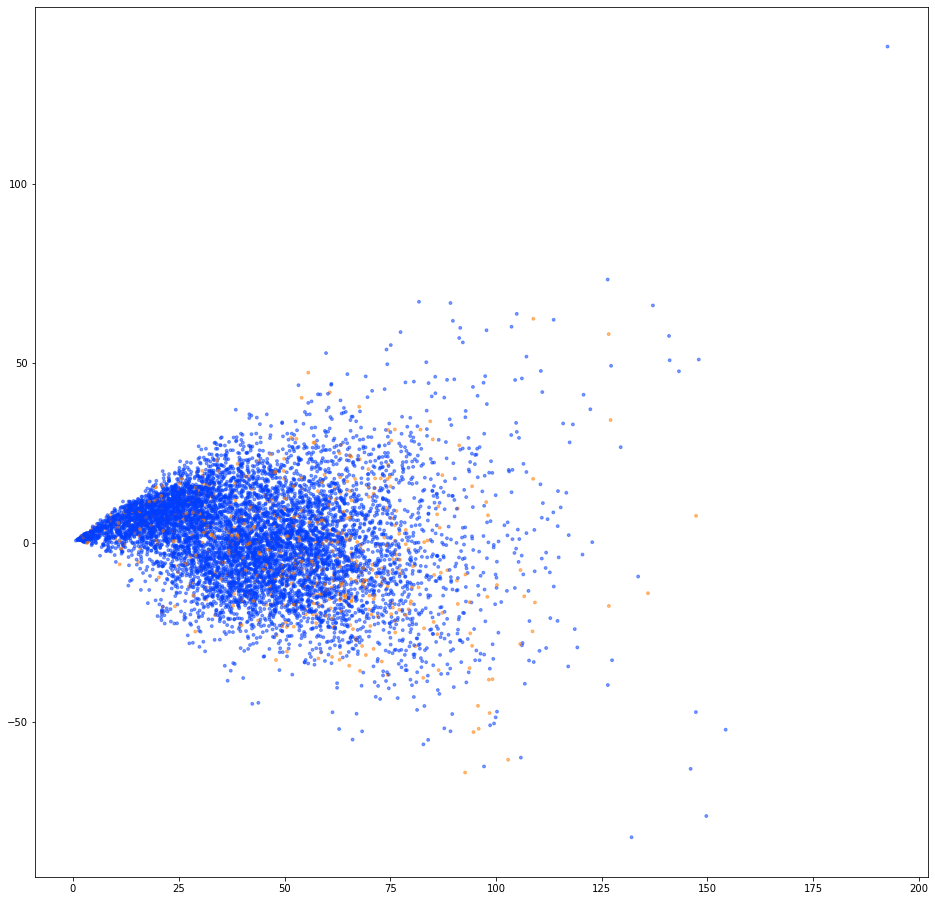

In [18]:
def plot_lsa(X, y,):
    lsa = TruncatedSVD() # defaults to n_components=2
    X_lsa = lsa.fit_transform(X)
    colors = sns.color_palette('bright')
    if len(set(y)) != 2:
        raise AttributeError('Multiclass not implemented')
    plt.scatter(X_lsa[:,0], X_lsa[:,1], s=8, alpha=.5, c=y, cmap=ListedColormap(colors[:2]))
    
fig = plt.figure(figsize=(16, 16))          
plot_lsa(X_test_vect, y_test)
plt.show()
    

In [19]:
weights_df = pd.DataFrame({'terms': vect.get_feature_names(),'weights': model.coef_.flatten(),})
weights_df.sort_values(by='weights', ascending=False)


,terms,weights
2745,trach,0.029315
1957,peg,0.028471
2560,subdural,0.026187
1518,liver,0.022418
2119,ptt,0.022039
...,...,...
402,care,-0.023385
738,discharge,-0.025095
2756,transferred,-0.025904
1223,hospice,-0.025999


## word2vec embedding

In [20]:
import gensim
import gensim.downloader as api

In [21]:
# load pre-trained model
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [32]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, text, stop_words=[], generate_missing=False):
    print("Tokenizing...")
    tokens = text.apply(lambda x: basic_tokenizer(x, stop_words=stop_words))
    print("Vectorizing...")
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [33]:
embeddings = get_word2vec_embeddings(wv, X, stop_words=my_stop_words2)

Tokenizing...
Vectorizing...


In [34]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, X_test_word2vec = train_test_split(embeddings, y, 
                                                                                        test_size=0.2, random_state=1)

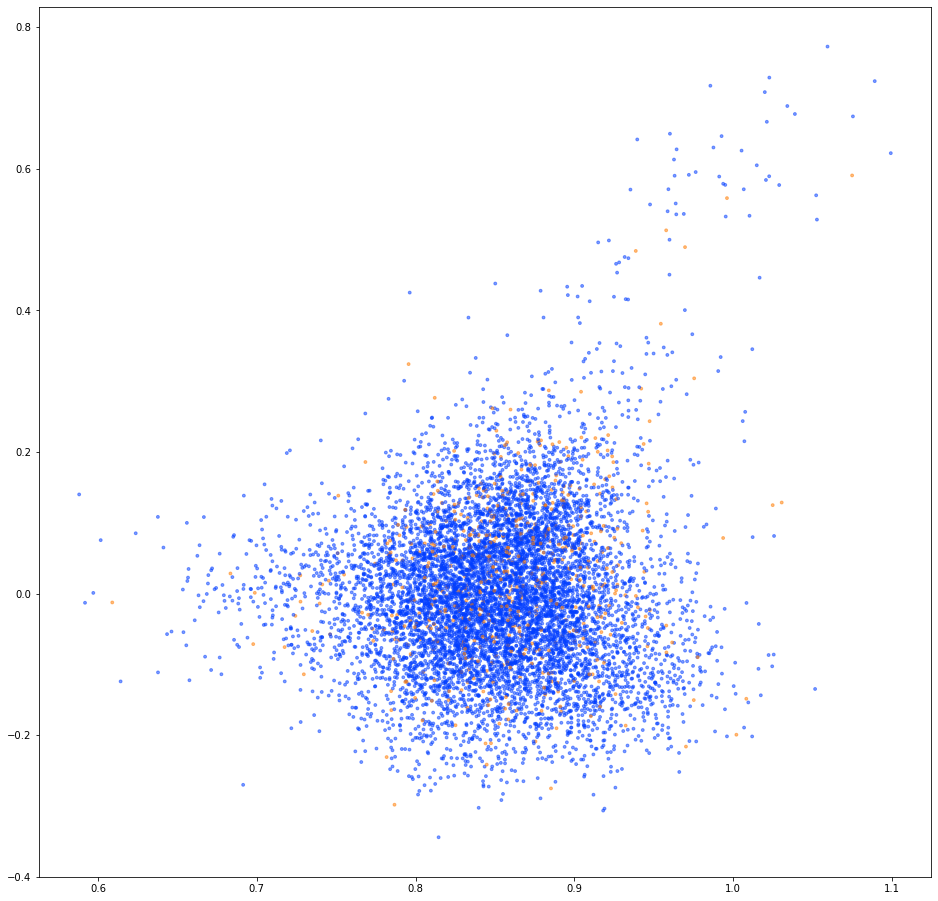

In [37]:
fig = plt.figure(figsize=(16, 16)) 
plot_lsa(X_test_word2vec, y_test_word2vec)
plt.show()

# NOTE: still doesn't look very separable in 2D

In [54]:
parameters = {
    'alpha': (0.0001, 0.00001, 0.000001,),
    'loss': ('hinge', 'log'),
    'penalty': ('l2', 'elasticnet'),
    'max_iter': (100,200,500),
}

grid_search = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=1)
print("Performing grid search...")
# print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train_word2vec, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'alpha': (0.0001, 1e-05, 1e-06),
 'loss': ('hinge', 'log'),
 'max_iter': (100, 200, 500),
 'penalty': ('l2', 'elasticnet')}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.2min finished


done in 493.523s

Best score: 0.683
Best parameters set:
	alpha: 1e-05
	loss: 'hinge'
	max_iter: 100
	penalty: 'l2'


In [55]:
model = grid_search.best_estimator_
print("Generating test predictions...")
y_test_pred = model.decision_function(X_test_word2vec)
test_auc = roc_auc_score(y_test, y_test_pred)
print("Test AUC: {:.3f}".format(test_auc))

Generating test predictions...
Test AUC: 0.702


## TF-IDF

In [120]:
# feed the bag-of-words into a TF-IDF vectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)

parameters = {
    'alpha': (1.0, 0.1, 0.01),
    'loss': ('hinge', 'log'),
    'penalty': ('l2', 'elasticnet'),
    'max_iter': (10,50,80),
}

grid_search_tfidf = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=1)
print("Performing grid search...")
# print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search_tfidf.fit(X_train_tfidf, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search_tfidf.best_score_)
print("Best parameters set:")
best_parameters = grid_search_tfidf.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
print("Creating bag-of-words on test set...")
X_test_tfidf = tfidf.transform(X_test)
model = grid_search_tfidf.best_estimator_
print("Generating test predictions...")
y_test_pred = model.decision_function(X_test_tfidf)
test_auc = roc_auc_score(y_test, y_test_pred)
print("Test AUC: {:.3f}".format(test_auc))

Performing grid search...
parameters:
{'alpha': (1.0, 0.1, 0.01),
 'loss': ('hinge', 'log'),
 'max_iter': (10, 50, 80),
 'penalty': ('l2', 'elasticnet')}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.8min finished


done in 233.147s

Best score: 0.666
Best parameters set:
	alpha: 0.01
	loss: 'log'
	max_iter: 50
	penalty: 'l2'
Creating bag-of-words on test set...
Generating test predictions...
Test AUC: 0.685


# CNN modeling

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [321]:
class TextCNN(nn.Module):
    """ Text CNN from Yoon Kim's 2014 paper: https://arxiv.org/pdf/1408.5882.pdf
    
    Params
    ------
    sequence_length : int
        The length (in words/tokens) of each sentence.
    num_classes : int
        Number of output classes.
    vocab_size : int
        The number of unique tokens in our vocabulary.
    embedding_size: int
        The vector length for word embeddings.
    filter_sizes: list(int)
        The kernel size for each desired filter (e.g. [3,4,5])
    num_filters: int
        The number of filters to apply.
    
    Returns
    -------
    model : nn.Module
    """
    def __init__(self, sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters):
        super(TextCNN, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        

Nursing/other        87919
Radiology            65049
Nursing              48932
Physician            33181
ECG                  28528
Discharge summary     9951
Respiratory           8011
Echo                  6188
Nutrition             2162
General               2116
Rehab Services        1268
Social Work            458
Case Management        329
Consult                 36
Pharmacy                12
Name: CATEGORY, dtype: int64

In [322]:
# keep only the top categories to analyze
note_categories = ['Nursing/other', 'Radiology', 'Nursing', 'Physician']

In [320]:
print(notes[notes['CATEGORY'] == 'Discharge summary'].iloc[5].TEXT)

Admission Date:  [**2105-4-16**]              Discharge Date:   [**2105-4-27**]

Date of Birth:  [**2044-3-8**]             Sex:   F

Service: MEDICINE

Allergies:
Penicillins

Attending:[**First Name3 (LF) 2344**]
Chief Complaint:
Airway monitoring

Major Surgical or Invasive Procedure:
[**2105-4-24**]: Right video-assisted thoraoscopy with decortication


History of Present Illness:
61 year old female with PMHX of HTH presented with severe sore
throat for 2 days rapidly getting worse associated with
difficulty swallowing liquids and neck pain. Also found to have
fever and tachycardia. Unable to take meds, only took BP meds
this am. Voice is hoarse and descrbed as "hot potato" by PCP.
[**Name10 (NameIs) 1403**] as a flight attendant, travelled all over Europe recently.
Sister with sore throat as well. In PCPs office, unable to open
her mouth, tender thick neck unable to evaluate pharynx. Per
report pts sore throat has progressed rapidly over past 2 days.
Unable to swallow her secretio

In [38]:
import nltk

In [95]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from string import punctuation

In [98]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/kevin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [336]:
stop_words = set(stopwords.words('english'))
def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.replace('_', '')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)

preprocess_sentence(notes.loc[0].TEXT)

"admission date 2118-6-2 discharge date 2118-6-14 date birth sex f service micu doctor last name medicine history present illness 81-year-old female history emphysema home o2 presents three days shortness breath thought primary care doctor copd flare two days prior admission started prednisone taper one day prior admission required oxygen home order maintain oxygen saturation greater 90 also levofloxacin nebulizers getting better presented hospital1 18 emergency room hospital3 emergency room oxygen saturation 100 cpap able weaned despite nebulizer treatment solu-medrol 125 mg iv x2 review systems negative following fevers chills nausea vomiting night sweats change weight gastrointestinal complaints neurologic changes rashes palpitations orthopnea positive following chest pressure occasionally shortness breath exertion shortness breath positionally related improved nebulizer treatment past medical history 1 copd last pulmonary function tests 2117-11-3 demonstrated fvc 52 predicted fev1 

In [307]:
print(notes.loc[1].TEXT)

Sinus rhythm
Consider left ventricular hypertrophy by voltage but may be within normal
limits
Since previous tracing of [**2118-6-2**], tachycardia and intraventricular conduction
delay absent




In [308]:
notes.loc[:10].TEXT

0     Admission Date:  [**2118-6-2**]       Discharg...
1     Sinus rhythm\nConsider left ventricular hypert...
2     Probable sinus tachycardia\nIntraventricular c...
3     Sinus tachycardia\nBaseline artifact\nSince pr...
4     [**2118-6-5**] 11:18 AM\n CHEST (PORTABLE AP) ...
5     [**2118-6-10**] 6:01 AM\n CHEST (PORTABLE AP) ...
6     [**2118-6-11**] 6:01 AM\n CHEST (PORTABLE AP);...
7     [**2118-6-12**] 6:54 PM\n CHEST (PORTABLE AP) ...
8     [**2118-6-2**] 8:31 AM\n CHEST (PORTABLE AP)  ...
9     [**2118-6-7**] 11:26 PM\n CHEST (PORTABLE AP) ...
10    [**2118-6-11**] 5:44 PM\n CHEST (PA & LAT)    ...
Name: TEXT, dtype: object

In [347]:
count = CountVectorizer(stop_words='english', preprocessor=preprocess_sentence, max_df=0.75)
# count = CountVectorizer(stop_words='english', preprocessor=preprocess_sentence)
bag = count.fit_transform(notes[notes.CATEGORY.isin(note_categories)].iloc[:300].TEXT)

In [333]:
count.get_feature_names()

['00',
 '0000',
 '01',
 '018',
 '01mcgs',
 '02',
 '0200',
 '03',
 '0300',
 '035',
 '04',
 '0400',
 '05',
 '0500',
 '0600',
 '0645',
 '07',
 '0700',
 '08',
 '0800',
 '0830',
 '09',
 '0900',
 '10',
 '100',
 '1000',
 '1000u',
 '1003',
 '100cc',
 '100ccs',
 '100mcg',
 '100mg',
 '100ml',
 '100s',
 '101',
 '1015',
 '102',
 '10207',
 '103',
 '104',
 '105',
 '1050',
 '1050u',
 '106',
 '1062',
 '106sr',
 '108',
 '1085ml',
 '109',
 '10a',
 '10cc',
 '10cchr',
 '10cm',
 '10mg',
 '10mins',
 '10pm',
 '10ps',
 '11',
 '110',
 '1100',
 '1115',
 '1115am',
 '112',
 '113',
 '114',
 '115',
 '1150units',
 '116',
 '117',
 '118',
 '1193',
 '11lpm',
 '12',
 '120',
 '1200',
 '120cc',
 '121',
 '1215',
 '123',
 '1230',
 '1240',
 '1245',
 '125',
 '1250u',
 '126',
 '1261',
 '128',
 '12cm',
 '12hrs',
 '12mcgs',
 '12n',
 '12pm',
 '12r',
 '13',
 '130',
 '1300',
 '13032',
 '13035',
 '13036',
 '13037',
 '13038',
 '13039',
 '13040',
 '13041',
 '13042',
 '13043',
 '13062',
 '13094',
 '13095',
 '130s',
 '13115',
 '13117',


In [349]:
vocab_lookup = {v:k for k,v in count.vocabulary_.items()}

In [348]:
doc_matrix = pd.DataFrame(bag.toarray())
doc_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,4719,4720,4721,4722,4723,4724,4725,4726,4727,4728
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [350]:
mean_freq = doc_matrix.mean().sort_values(ascending=False).rename('freq_mean')[:30]
mean_freq.to_frame().index.map(vocab_lookup)

Index(['placement', 'noted', 'hr', 'ct', 'patient', 'placed', 'today', 'copd',
       'portable', 'pulmonary', 'small', 'line', 'pleural', 'o2', 'contrast',
       'remains', 'iv', 'stable', '10', 'pain', 'assessment', 'findings',
       'change', '12', '100', 'post', 'pneumonia', 'increased', 'response',
       'bs'],
      dtype='object')

In [351]:
len(count.get_stop_words())

318

In [171]:
df1 = pd.read_excel('/Users/kevin/Documents/HGE/Adherium/DataForImport_20200728.xlsx')
df1.head()

,System ID,Last Name,First Name,Gender,DOB,Primary Phone,Secondary Phone,Address 1,Address 2,City,State,Zip Code,Facility,HGEMed Enrollment Date,May Check-In Rate,June Check-In Rate,App User,Call Only
0,2649,Giessmann,Roger,NaN,1940-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK - Muscogee Creek,2020-02-27 11:11:47,0.97,0.97,No,False
1,2671,Mitchell,Ella,NaN,1960-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK - Muscogee Creek,2020-02-29 17:58:47,0.50,0.60,Yes,False
2,2672,Turner,Rodney,NaN,1966-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK - Muscogee Creek,2020-03-01 13:37:32,0.93,0.93,No,False
3,2673,Dowling,Gary,NaN,1959-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK - Muscogee Creek,2020-03-01 13:37:45,0.90,0.90,Yes,False
4,2760,Sparks,Jeffery,NaN,1964-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK - Muscogee Creek,2020-03-20 15:33:44,0.31,0.63,Yes,False


In [194]:
df2 = pd.read_csv('/Users/kevin/Documents/HGE/HSX/202007/HGE_ENS_20200727.csv', dtype={'Zip': 'str', 'Patient ID': int})
cols = ['Patient ID', 'Gender', 'Address_Line_1', 'Address_Line_2', 'City', 'State', 'Zip', 'Phone_Primary', 'Phone_Alt1', 'Phone_Alt2']
df2[cols].head()

,Patient ID,Gender,Address_Line_1,Address_Line_2,City,State,Zip,Phone_Primary,Phone_Alt1,Phone_Alt2
0,8,Male,7419 Queens Way,NaN,Ellenton,Florida,34222,609-617-0050,609-617-0050,NaN
1,12,Male,1222 Woodside Ave.,NaN,Hatfield,Pennsylvania,19440,215-855-2489,215-855-2489,NaN
2,13,Male,2837 N 9th St,NaN,Philadelphia,Pennsylvania,19133,215-609-7017,NaN,NaN
3,15,Female,3 Dartmouth Road,NaN,Somers Point,New Jersey,08244,609-602-1732,609-601-2225,NaN
4,18,Male,3543 Edgewater Lane,NaN,Brookhaven,Pennsylvania,19015,610-876-3725,484-477-6057,NaN


In [205]:
df2[df2['Patient ID'] == 1104]

,Patient ID,Data Source ID,Patient Group ID,First_Name,Middle_Name,Last_Name,Name_Suffix,Address_Line_1,Address_Line_2,City,...,Date_Of_Birth,Gender,SSN,Phone_Primary,Phone_Alt1,Phone_Alt2,PrimaryCareProvider,SiteName,Insurance,Care_Manager_Name


In [207]:
mrg = df1[df1['Facility'] != 'Demo'].merge(df2[cols], left_on='System ID', right_on='Patient ID', how='left')
mrg.to_excel("/Users/kevin/Downloads/temp.xlsx", index=False)
# mrg.columns

In [196]:
df1[df1['Facility'].str.contains('OK')].shape

(15, 18)

In [193]:
df2[df2.Gender.str.len() == 1]

,Patient ID,Data Source ID,Patient Group ID,First_Name,Middle_Name,Last_Name,Name_Suffix,Address_Line_1,Address_Line_2,City,...,Date_Of_Birth,Gender,SSN,Phone_Primary,Phone_Alt1,Phone_Alt2,PrimaryCareProvider,SiteName,Insurance,Care_Manager_Name
817,2537,HGEPAN,HGEHS,Cheryl,NaN,McDonald,NaN,500 W 67th Avenue,Apartment #2,Philadelphia,...,10/08/1956,F,NaN,267-776-3143,NaN,NaN,NaN,NaN,NaN,NaN
818,2547,HGEPAN,HGEHS,Michele,NaN,Beasley,NaN,159 Gulph Lane,NaN,Gulph Mills,...,06/19/1957,F,NaN,610-941-0932,484-213-1439,NaN,NaN,NaN,Personal Choice,NaN
819,2555,HGEPAN,HGEHS,Arlene,NaN,Daniels,NaN,1328 Levick St,NaN,Philadelphia,...,08/01/1945,F,NaN,267-512-0769,215-744-6976,NaN,Ellen Gambrah,NaN,NaN,NaN
820,2585,HGEPAN,HGEHS,John,NaN,Baylis,NaN,30 Festival Drive,NaN,Voorhees,...,12/17/1942,M,NaN,609-941-1984,NaN,NaN,NaN,NaN,Medicare,NaN
821,2607,HGEPAN,HGEHS,Edward,NaN,Matthews,NaN,7710 Lancaster Ave,NaN,Myerstown,...,11/17/1950,M,NaN,609-617-9052,NaN,NaN,NaN,NaN,Medicare,NaN
822,2619,HGEPAN,HGEHS,Ann,NaN,Knudson,NaN,108 South Lincoln Avenue,NaN,Newtown,...,06/23/1942,F,NaN,267-206-7737,NaN,NaN,NaN,NaN,Aetna - Medicare,NaN
823,2656,HGEPAN,HGEHS,Kevin,NaN,Walls,NaN,5645 Matthews Street,NaN,Philadelphia,...,06/04/1963,M,NaN,267-254-0357,NaN,NaN,NaN,NaN,Aetna - PPO,NaN
824,2659,HGEPAN,HGEHS,Olwen,NaN,Hollock,NaN,7105 Queenscourt Lane,NaN,Macungie,...,06/27/1940,F,NaN,908-578-0473,610-395-6669,NaN,NaN,NaN,NaN,NaN
825,2663,HGEPAN,HGEHS,Rosa,NaN,Garcia,NaN,401 East Somerset Street,First Floor (Front),Philadelphia,...,10/03/1956,F,NaN,267-444-9276,NaN,NaN,NaN,NaN,Keystone-First,NaN
826,2700,HGEPAN,HGEHS,Brian,NaN,Sleister,NaN,170 Hughes Avenue,NaN,Sellersville,...,09/12/1971,M,NaN,609-442-9228,NaN,NaN,NaN,NaN,Keystone-First,NaN


In [217]:
cols = ['System ID', 'Last Name', 'First Name','DOB','Facility','HGEMed Enrollment Date',
       'May Check-In Rate', 'June Check-In Rate', 'App User', 'Call Only','Gender_y', 'Address_Line_1', 'Address_Line_2', 'City_y',
       'State_y', 'Zip', 'Phone_Primary', 'Phone_Alt1']

df3 = pd.read_excel("/Users/kevin/Downloads/temp.xlsx", dtype={'Zip': 'str'})[cols]
df3 = df3.rename(columns={
    'Gender_y': 'Gender',
    'City_y': 'City',
    'State_y': 'State',
    'Phone_Primary': 'Primary Phone',
    'Phone_Alt1': 'Secondary Phone',
})

df3['Hunt Group'] = 'Temple'
df3.loc[df3.Facility.str.contains('OK'), 'Hunt Group'] = 'Oklahoma'
df3


,System ID,Last Name,First Name,DOB,Facility,HGEMed Enrollment Date,May Check-In Rate,June Check-In Rate,App User,Call Only,Gender,Address_Line_1,Address_Line_2,City,State,Zip,Primary Phone,Secondary Phone,Hunt Group
0,2649,Giessmann,Roger,1940-07-21,OK - Muscogee Creek,2020-02-27 11:11:47,0.97,0.97,No,False,Male,2019 N Oklahoma Ave,NaN,Okmulgee,Oklahoma,74447,918-756-2727,NaN,Oklahoma
1,2671,Mitchell,Ella,1960-06-05,OK - Muscogee Creek,2020-02-29 17:58:47,0.50,0.60,Yes,False,Female,110364 S 4190 Rd,NaN,Checotah,Oklahoma,74426,918-490-2608,NaN,Oklahoma
2,2672,Turner,Rodney,1966-11-01,OK - Muscogee Creek,2020-03-01 13:37:32,0.93,0.93,No,False,Male,8703 W 81st St,Trlr 24,Tulsa,Oklahoma,74131,918-231-9279,NaN,Oklahoma
3,2673,Dowling,Gary,1959-11-01,OK - Muscogee Creek,2020-03-01 13:37:45,0.90,0.90,Yes,False,Male,29803 S Highway 2,NaN,Porum,Oklahoma,74455,918-557-6247,NaN,Oklahoma
4,2760,Sparks,Jeffery,1964-10-22,OK - Muscogee Creek,2020-03-20 15:33:44,0.31,0.63,Yes,False,Male,PO Box 172,NaN,Wetumka,Oklahoma,74883,760-399-0816,NaN,Oklahoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,1797,Trapp,Diane,1957-04-22,TUP - Temple Lung Center,2019-05-14 16:59:10,0.70,0.73,No,True,Female,1918 E Monmouth Street,NaN,Philadelphia,Pennsylvania,19134,215-634-3986,NaN,Temple
179,1813,Daniels,Robert,1934-10-02,TUP - Temple Lung Center,2019-05-17 10:22:32,0.70,0.83,No,True,Male,4649 Paul Street Apartment 105,NaN,Philadelphia,Pennsylvania,19124,215-954-3300,215-327-6368,Temple
180,1822,Poole,Linda,1950-09-19,TUP - Temple Lung Center,2019-05-21 10:25:55,0.67,0.43,No,True,Female,40 Riverwalk South,Apt. 112,Bridgeton,New Jersey,08302,856-451-7407,856-392-3791,Temple
181,2139,Decker,Barbara,1943-10-08,TUP - Temple Lung Center,2019-07-15 13:04:18,1.00,1.00,No,True,Female,843 Linton Avenue,NaN,Croydon,Pennsylvania,19021,215-785-5733,NaN,Temple


In [367]:
# df = pd.read_csv("~/Downloads/Check_Ins (1).csv", encoding='iso-8859-1', parse_dates=['Check-In Received'])
# df = df[df['Check-In ID'] >= 100000000]
# df.replace({'yes': 'YES', 'no': "NO"}, inplace=True)
cols = ['Check-In Received',
       'CovidCare System ID', 'Check-In ID', 'Virus Status', 'Household Virus',
       'Healthcare Worker', 'Household Healthcare Worker',
       'Household Active Worker', 'Not Actively Out', 'Virus Quarantine',
       'Physical Feeling', 'Temperature', 'Temperature Method',
       'Fever/Feverish', 'Cough', 'Cough Difference', 'Short of Breath',
       'Short of Breath Difference', 'Body Aches', 'Chills', 'Fatigue',
       'Headache', 'Sore Throat', 'Runny Nose', 'Diarrhea', 'Loss of Smell',
       'Loss of Taste', 'Risk Factors',]
df[cols].to_csv("~/Downloads/July2020_CovidCare_IVR_Checkins.csv", index=False)